# Week 3: CNN Cancer Detection Kaggle Mini-Project


**Problem Description**

This week's project works with image classification.    Specifically, it focuses on nearly 220,000 images of cancer cells with labels of benign or malignant. I chose to use convolutional neural networks (CNN basic and complex) to identify patterns and features that could indicate the presence or absence of cancer.  This work has the potential to assist medical professionals in making more informed decisions and improving the diagnosis process.

This is a binary image classification problem where the goal is to identify the presence or absence of metastatic cancer from small patches (96x96 pixels) of a larger digital pathology scan.     Each image corresponds to a label:
1: The presence of metastatic cancer.
0: There is no metastatic cancer.



**Dataset Description**

DataSource: [Histopathologic Cancer Detection on Kaggle](https://www.kaggle.com/c/histopathologic-cancer-detection/) 

In this dataset, 22,000 pathological images need to be classified. There are two folders: train for training samples and test for validation samples. In train_label.csv, the id column records the file name of the pathological image, and lable records the label.

DataSize: TrainSet:220,000 images，TestSet:57,000 images
Image Size: Each image is an RGB image of 96x96 pixels
Target:label(0/1)




**Conclusion**

In this project, I construct and optimize a deep learning model based on convolutional neural network (CNN) for the binary classification problem of histopathological cancer detection. The main results and summary of the project are as follows:
1. Data scale
Train images ：1000
Epochs ：10

2. Model performance improvement
Basic CNN model:
Verification set accuracy: 61%
AUC: 0.7065
The model after adjusting hyperparameters:
Verification set accuracy: 70%
AUC: 0.8268
By adjusting the hyperparameters, the verification set accuracy of the model is improved by 9.5% and the AUC is improved by 0.1203. This shows that hyperparameter optimization significantly improves the classification performance and generalization ability of the model.

3. Key improvement measures
Hyperparameter adjustment:
Use smaller learning rates (e.g. 0.0001) and learning rate scheduling (e.g. ReduceLROnPlateau) to make the training process more stable.
Adjust batch size and Dropout rate to reduce overfitting.
Data enhancement:
By means of data enhancement techniques such as random rotation, translation, scaling and flipping, the diversity of training data is increased and the generalization ability of the model is improved.
Model architecture optimization:
The convolutional layer and fully connected layer are added to improve the expressiveness of the model.
The L2 regularization and Dropout layers are added to further reduce overfitting.

4. Result analysis
Verification set accuracy:
After adjusting the hyperparameters, the validation set accuracy of the model is improved from 61% to 70%, indicating that the classification ability of the model on unseen data is significantly enhanced.


# Import libraries

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight

import os
import numpy as np
import pandas as pd
import random
import shutil
from PIL import Image
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Exploratory data analysis（EDA）

**Loading data**
**Look at the label distribution**

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Train Size: 220025
train_labels: 0.41


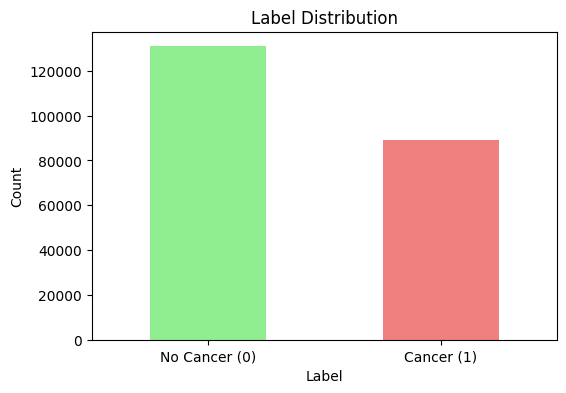

In [49]:
# load 
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# view data
print(train_labels.head())
print(f"Train Size: {len(train_labels)}")
print(f"train_labels: {train_labels['label'].mean():.2f}")


# Label Distribution
plt.figure(figsize=(6, 4))
train_labels['label'].value_counts().plot(kind='bar', color=['lightgreen', 'lightcoral'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks([0, 1], ['No Cancer (0)', 'Cancer (1)'], rotation=0)
plt.show()

# Sample images


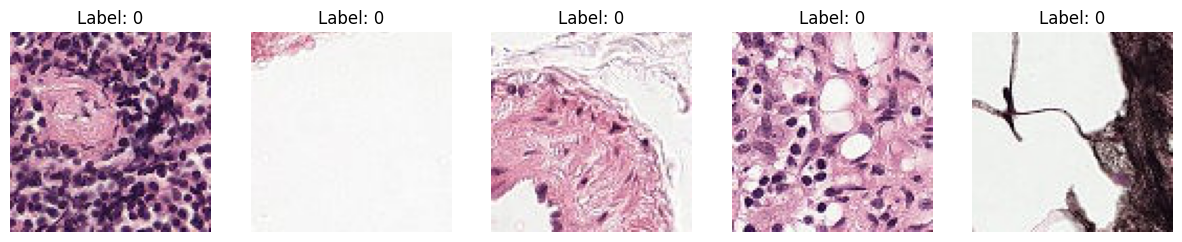

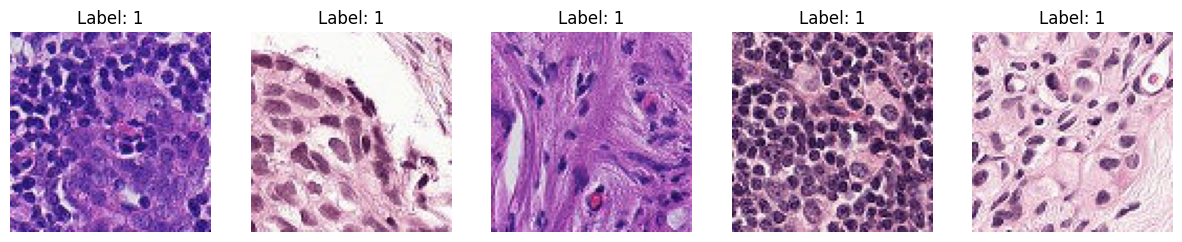

In [50]:

def plot_sample_images(df, path, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i, (_, row) in enumerate(df.sample(num_samples).iterrows()):
        img_id = row['id']
        label = row['label']
        img = Image.open(os.path.join(path, f"{img_id}.tif"))
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# sample_images_label_0 / sample_images_label_1
sample_images_label_0 = train_labels[train_labels['label'] == 0].sample(6)
sample_images_label_1 = train_labels[train_labels['label'] == 1].sample(6)
plot_sample_images(sample_images_label_0, '''/kaggle/input/histopathologic-cancer-detection/train''')
plot_sample_images(sample_images_label_1, '/kaggle/input/histopathologic-cancer-detection/train')


# EDA Data Cleaning

**check whether there are missing and image damage**

**Check Missing values**

**Check The Corrupted images**

In [51]:
# top XXX images
train_data = train_labels.head(1000)
train_data.to_csv('train_data.csv', index=False)

print(f"Missing values: {train_data.isnull().sum()}")

def check_image_corruption(df, path):
    corrupted_images = []
    for img_id in df['id']:
        try:
            img = Image.open(os.path.join(path, f"{img_id}.tif"))
            img.verify()  
        except Exception as e:
            corrupted_images.append(img_id)

    return corrupted_images

corrupted_images = check_image_corruption(train_data, '/kaggle/input/histopathologic-cancer-detection/train')
print(f"Corrupted images: {len(corrupted_images)}")


Missing values: id       0
label    0
dtype: int64
Corrupted images: 0


# EDA Data preprocessing

**Optimize parameters - Add data enhancement**

Found 800 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
----Train----
Image Count: 800
Indexs: {'0': 0, '1': 1}
----Validator----
Image Count: 200
Indexs: {'0': 0, '1': 1}
Images: (16, 96, 96, 3)
Targets: (16,)


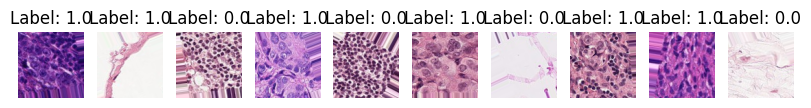

In [52]:
# create temp directory
os.makedirs('/kaggle/temp/train/0', exist_ok=True)
os.makedirs('/kaggle/temp/train/1', exist_ok=True)

# Optimize parameters - Add data enhancement
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

for _, row in train_data.iterrows():
    src_path = os.path.join('/kaggle/input/histopathologic-cancer-detection/train', f"{row['id']}.tif")
    dst_path = os.path.join('/kaggle/temp/train', str(row['label']), f"{row['id']}.tif")
    shutil.copy(src_path, dst_path)

# Use temp_directory
train_generator = datagen.flow_from_directory(
    directory='/kaggle/temp/train',
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary',
    subset='training',
    seed=42
)

val_generator = datagen.flow_from_directory(
    directory='/kaggle/temp/train',
    target_size=(96, 96),
    batch_size=16,
    class_mode='binary',
    subset='validation',
    seed=42
)

# 检查生成器的输出
print("----Train----")
print(f"Image Count: {train_generator.samples}")
print(f"Indexs: {train_generator.class_indices}")

print("----Validator----")
print(f"Image Count: {val_generator.samples}")
print(f"Indexs: {val_generator.class_indices}")

# 获取一个批次的数据
x_batch, y_batch = next(train_generator)

# 检查数据形状
print(f"Images: {x_batch.shape}")
print(f"Targets: {y_batch.shape}")

# 可视化一个批次的图像
plt.figure(figsize=(10, 5))
for i in range(min(10, x_batch.shape[0])):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {y_batch[i]}")
    plt.axis('off')
plt.show()

In [53]:
def load_images(df, path):
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(path, f"{row['id']}.tif")
        img = Image.open(img_path)
        img = img.resize((96, 96))
        img = np.array(img) / 255.0  # 归一化
        images.append(img)
        labels.append(row['label'])
    return np.array(images), np.array(labels)

# 加载调试数据
x_train, y_train = load_images(train_data, '/kaggle/input/histopathologic-cancer-detection/train')



Benign images shape: (5, 96, 96, 3)
Malignant images shape: (5, 96, 96, 3)


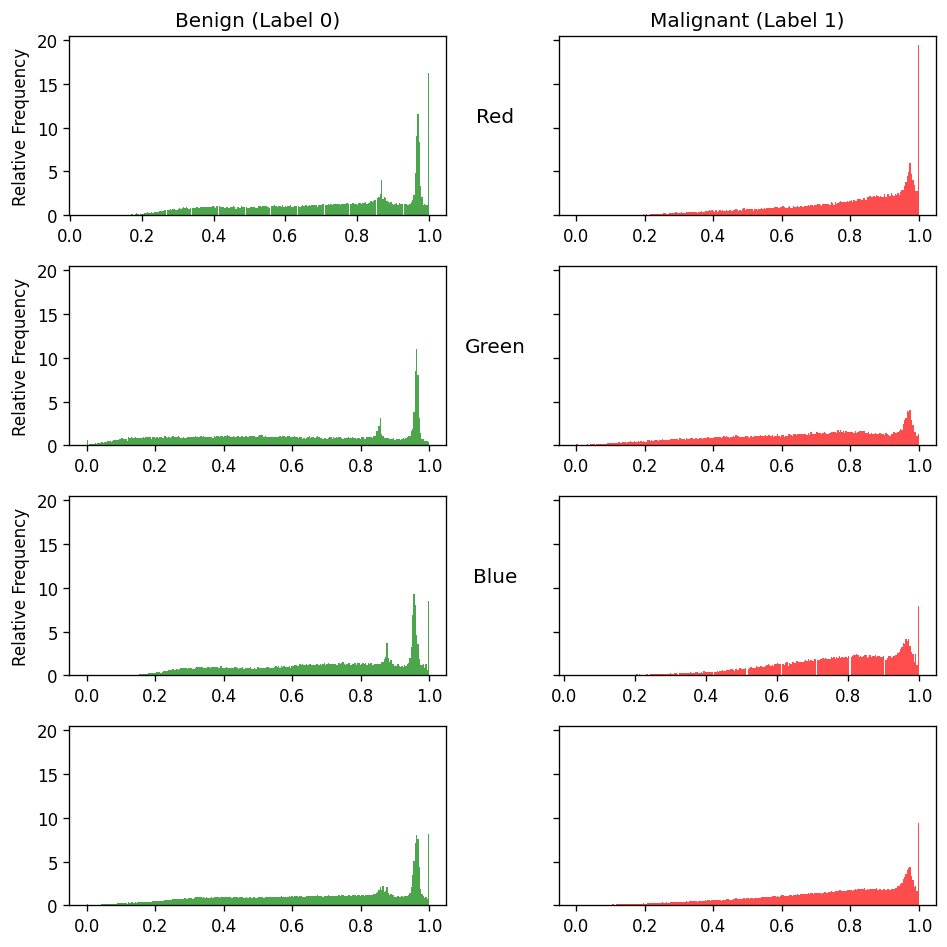

In [54]:
def load_image_type(df, path):
    benign_images = []
    malignant_images = []
    for _, row in df.iterrows():
        img_path = os.path.join(path, f"{row['id']}.tif")
        img = Image.open(img_path)
        img = img.resize((96, 96))
        img = np.array(img) / 255.0
        if row['label']==0 :
            if len(benign_images)<5:
                benign_images.append(img)
        else :
            if len(malignant_images)<5:
                malignant_images.append(img)
    return np.array(benign_images), np.array(malignant_images)

# 加载调试数据
benign_images, malignant_images = load_image_type(train_data, '/kaggle/input/histopathologic-cancer-detection/train')

# Check the shapes of the loaded data
print(f"Benign images shape: {benign_images.shape}")
print(f"Malignant images shape: {malignant_images.shape}")



nr_of_bins = 256  # Each possible pixel value (0-255) gets a bin
fig, axs = plt.subplots(4, 2, sharey=True, figsize=(8, 8), dpi=120)  # Create a 4x2 plot grid
rgb_list = ["Red", "Green", "Blue", "RGB"]

# Loop through rows (RGB channels and combined) and columns (benign and malignant)
for row_idx in range(0, 4):
    for col_idx in range(0, 2):
        if row_idx < 3:
            axs[row_idx, 0].set_ylabel("Relative Frequency")
            axs[row_idx, 1].set_ylabel(rgb_list[row_idx], rotation="horizontal",
                                       labelpad=35, fontsize=12)
            # Plot histograms for RGB channels
            if col_idx == 0:  # Benign (label 0)
                axs[row_idx, 0].hist(benign_images[:, :, :, row_idx].flatten(),
                                     bins=nr_of_bins, density=True, color='green', alpha=0.7)
            elif col_idx == 1:  # Malignant (label 1)
                axs[row_idx, 1].hist(malignant_images[:, :, :, row_idx].flatten(),
                                     bins=nr_of_bins, density=True, color='red', alpha=0.7)
        else:
            # Plot histograms for combined RGB intensities
            if col_idx == 0:  # Benign (label 0)
                axs[row_idx, 0].hist(benign_images.flatten(),
                                     bins=nr_of_bins, density=True, color='green', alpha=0.7)
            elif col_idx == 1:  # Malignant (label 1)
                axs[row_idx, 1].hist(malignant_images.flatten(),
                                     bins=nr_of_bins, density=True, color='red', alpha=0.7)

# Add titles for columns
axs[0, 0].set_title("Benign (Label 0)")
axs[0, 1].set_title("Malignant (Label 1)")

# Show the plots
plt.tight_layout()
plt.show()


# Model building

**Building a simple CNN model**

**Model Training**


In [55]:

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# sample CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

cnn_history = cnn_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=16,
    verbose=1
)

cnn_val_accuracy = cnn_model.evaluate(x_val, y_val, verbose=0)[1]
print(f"sample CNN accuracy value: {cnn_val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 30976)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 64)                  │       1,982,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,001,985 (7.64 MB)

 Trainable params: 2,001,985 (7.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.5118 - loss: 1.0582 - val_accuracy: 0.6100 - val_loss: 0.6616
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5794 - loss: 0.6929 - val_accuracy: 0.6100 - val_loss: 0.6675
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5973 - loss: 0.6707 - val_accuracy: 0.6100 - val_loss: 0.6491
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.5968 - loss: 0.6693 - val_accuracy: 0.6100 - val_loss: 0.6494
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.6039 - loss: 0.6657 - val_accuracy: 0.6100 - val_loss: 0.6358
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.5650 - loss: 0.6597 - val_accuracy: 0.6100 - val_loss: 0.6687
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.6002 - loss: 0.6383 - val_accuracy: 0.6100 - val_loss: 0.6730
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.5908 - loss: 0.6668 - val_accuracy: 0.6400 - v

# Visualizing training results

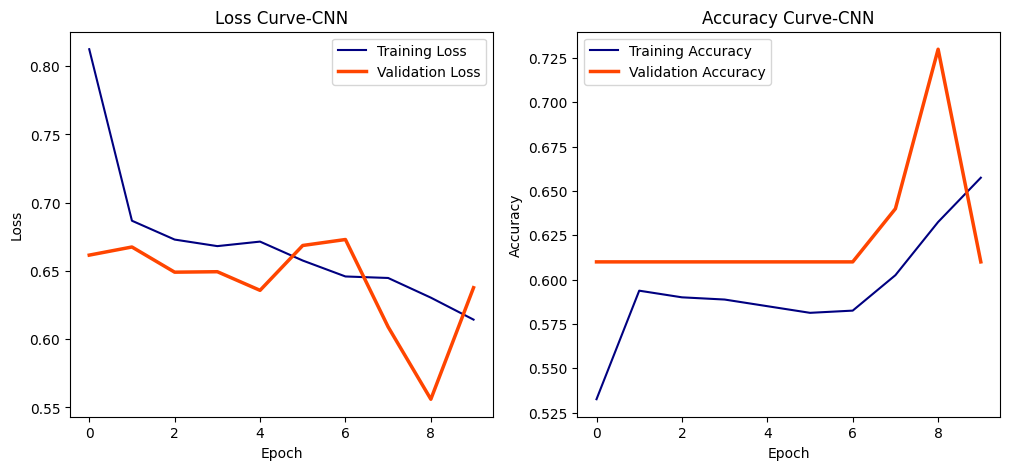

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
CNN_AUC: 0.7065


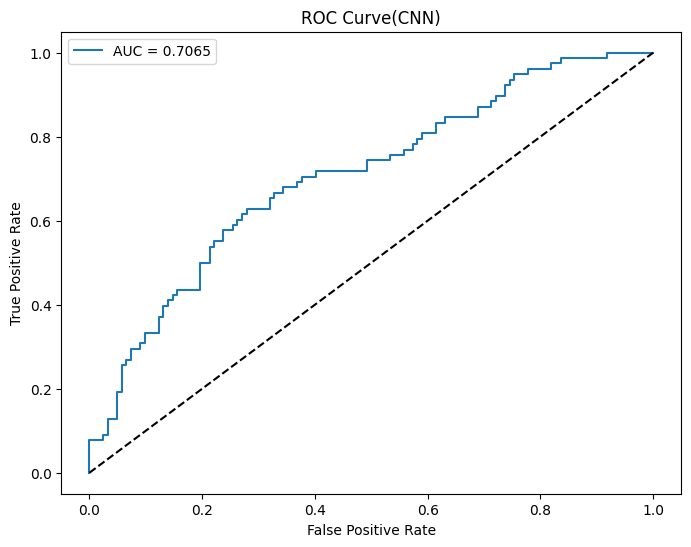

In [56]:
plt.figure(figsize=(12, 5))
# Loss Curve（CNN）
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Training Loss', color='navy')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss', color='orangered',linewidth='2.5')
plt.title('Loss Curve-CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Accuracy Curve（CNN）
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC
y_pred_prob = cnn_model.predict(x_val).ravel() 
cnn_auc = roc_auc_score(y_val, y_pred_prob)
print(f"CNN_AUC: {cnn_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# ROC 
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {cnn_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve(CNN)')
plt.legend()
plt.show()


# Adjust hyperparameter

In [57]:
complex_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.001), input_shape=(96, 96, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
# By adjusting hyperparameters, the training process of the model is optimized
# smaller learning_rate
optimizer = Adam(learning_rate=0.0001)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
complex_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#complex_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
complex_model.summary()

'''
# train model
complex_history = complex_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=20,
    batch_size=32,
    callbacks=[reduce_lr],
    verbose=1
)
cnn_val_accuracy = complex_model.evaluate(x_val, y_val, verbose=0)[1]
print(f"-------- CNN accuracy value: {cnn_val_accuracy:.4f}")
'''

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

complex_history = complex_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=10,
    batch_size=32,
    class_weight=class_weights,
    verbose=1
)
complex_val_accuracy = complex_model.evaluate(x_val, y_val, verbose=0)[1]
print(f"Adjust hyperparameter accuracy value: {complex_val_accuracy:.4f}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_22 (Conv2D)                   │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_24 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,740,097 (6.64 MB)

 Trainable params: 1,740,097 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 225ms/step - accuracy: 0.5387 - loss: 1.1533 - val_accuracy: 0.5150 - val_loss: 1.1084
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.5369 - loss: 1.0896 - val_accuracy: 0.6750 - val_loss: 1.0449
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step - accuracy: 0.5712 - loss: 1.0687 - val_accuracy: 0.6900 - val_loss: 0.9876
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - accuracy: 0.6242 - loss: 0.9958 - val_accuracy: 0.5500 - val_loss: 0.9859
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 214ms/step - accuracy: 0.6771 - loss: 0.9472 - val_accuracy: 0.7500 - val_loss: 0.8854
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - accuracy: 0.6744 - loss: 0.9180 - val_accuracy: 0.7150 - val_loss: 0.8524
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.7037 - loss: 0.8591 - val_accuracy: 0.6750 - val_loss: 0.8671
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 211ms/step - accuracy: 0.7170 - loss: 0.8529 - val_accuracy: 0.

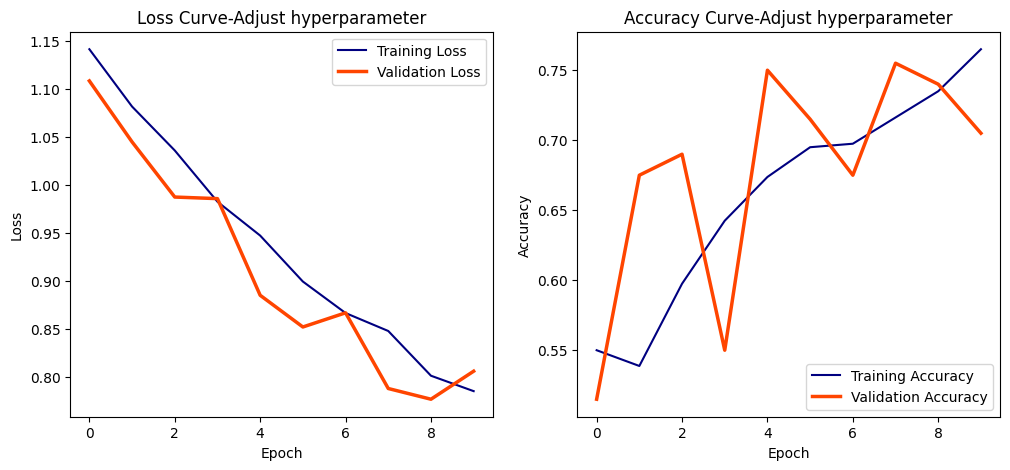

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Adjust hyperparameter AUC: 0.8268


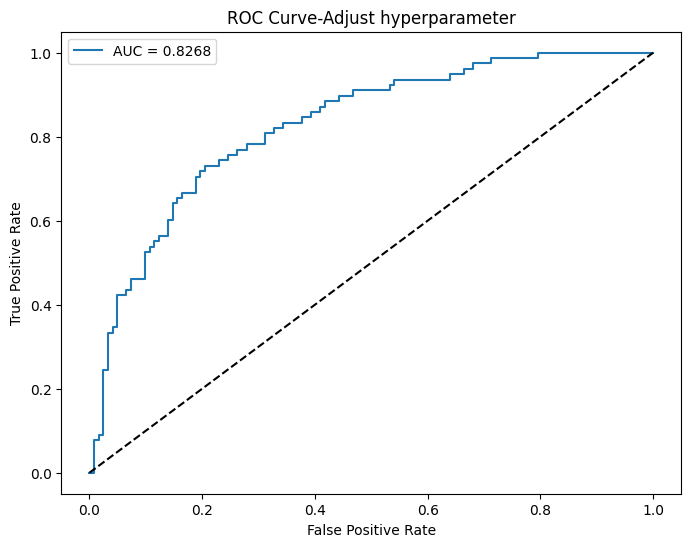

In [62]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(complex_history.history['loss'], label='Training Loss', color='navy')
plt.plot(complex_history.history['val_loss'], label='Validation Loss', color='orangered',linewidth='2.5')
plt.title('Loss Curve-Adjust hyperparameter')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-Adjust hyperparameter')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# AUC
y_pred_prob = complex_model.predict(x_val).ravel()
complex_auc = roc_auc_score(y_val, y_pred_prob)
print(f"Adjust hyperparameter AUC: {complex_auc:.4f}")
# 计算 ROC 曲线
fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {complex_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')  # 随机猜测的基线
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-Adjust hyperparameter')
plt.legend()
plt.show()


**最后做两个模型的对比**


In [59]:
print(f"Sample CNN: {cnn_val_accuracy:.4f}")
print(f"Adjust hyperparameter: {complex_val_accuracy:.4f}")

print(f"Rise: {(complex_val_accuracy - cnn_val_accuracy) * 100:.2f}%")

Sample CNN: 0.6100
Adjust hyperparameter: 0.7050
Rise: 9.50%


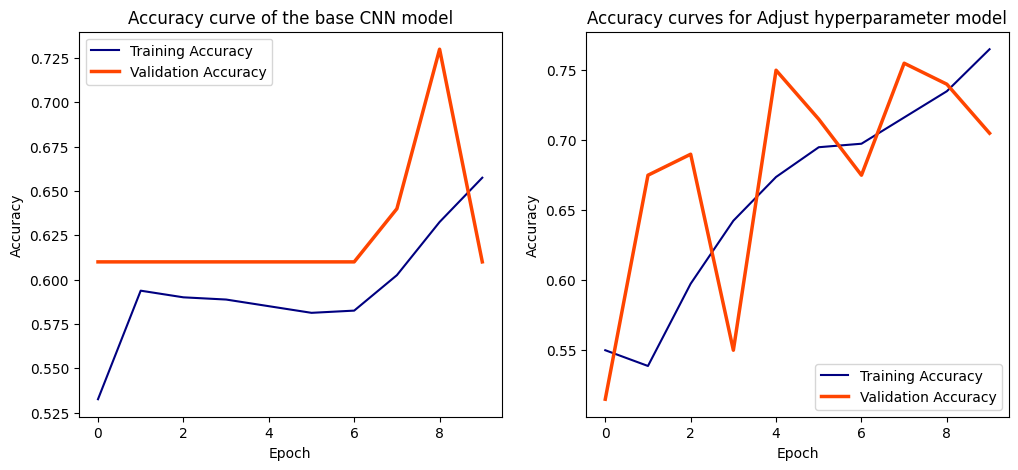

In [60]:
# CNN
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy Curve-Adjust hyperparameter')

plt.title('Accuracy curve of the base CNN model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Adjust
plt.subplot(1, 2, 2)
plt.plot(complex_history.history['accuracy'], label='Training Accuracy', color='navy')
plt.plot(complex_history.history['val_accuracy'], label='Validation Accuracy', color='orangered',linewidth='2.5')
plt.title('Accuracy curves for Adjust hyperparameter model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


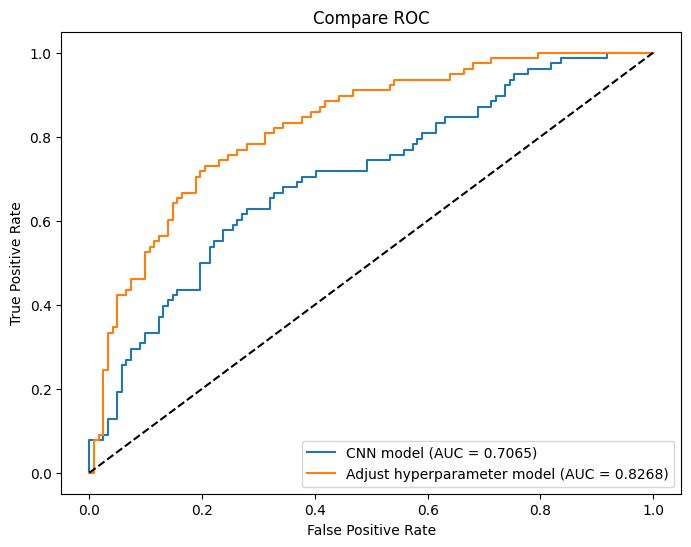

In [61]:
#compare ROC and AUC
cnn_pred_prob = cnn_model.predict(x_val).ravel()
complex_pred_prob = complex_model.predict(x_val).ravel()

# ROC
cnn_fpr, cnn_tpr, _ = roc_curve(y_val, cnn_pred_prob)
complex_fpr, complex_tpr, _ = roc_curve(y_val, complex_pred_prob)

# AUC
cnn_auc = roc_auc_score(y_val, cnn_pred_prob)
complex_auc = roc_auc_score(y_val, complex_pred_prob)

plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN model (AUC = {cnn_auc:.4f})')
plt.plot(complex_fpr, complex_tpr, label=f'Adjust hyperparameter model (AUC = {complex_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Compare ROC')
plt.legend()
plt.show()